# Прогнозирование вероятности оттока пользователей для фитнес-центров


<div class="alert alert-block alert-info">

### Описание проекта    
    
Сеть фитнес-центров «Адреналин» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Чтобы бороться с оттоком, отдел по работе с клиентами «Адреналина» перевёл в электронный вид множество клиентских анкет.     
Цель проекта — провести анализ и подготовить план действий по удержанию клиентов.  

А именно: 
- научиться прогнозировать вероятность оттока на следующий месяц для каждого клиента
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства
- проанализировать основные признаки, наиболее сильно влияющие на отток
- сформулировать выводы и разработать рекомендации по повышению качества работы с клиентами

В исходнике есть 13 полей признаков, которые так или иначе описывают клиента и его действия. На основе машинного обучения необходимо оценить влияние каждого из этих признаков на отточность (склонность ухода в отток) клиента.
        
</div>

### Загрузка и предобработка данных

In [1]:
# загружаем необходимые библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import phik

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage
import itertools
from sklearn.cluster import KMeans


In [2]:
# загрузим данные и ознакамливаемся с содержимым

try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# оценим размер выборки

df.shape

(4000, 14)

In [5]:
# переименовываем названия столбцов 
df.columns = df.columns.str.lower()

# убедимся в отсутствии пропусков и в соответствии типов данных с содержимым столбцов:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [6]:
df.duplicated().sum()

0

<div class="alert alert-block alert-info">

    
В исходнике есть 13 полей признаков 4000 клиентов, которые так или иначе описывают клиента и его действия. На основе машинного обучения необходимо оценить влияние каждого из этих признаков на отточность (склонность ухода в отток) клиента.
    
Для определения склонности к оттоку в работе планирую использовать алгоритм обучения с учителем - логистическую регрессию, т.к. факт оттока у нас обозначается бинарной величиной (0-удержан, 1-ушел в отток). Так же буду использовать алгоритм случайный лес, для сравнения метрик и выбора лучшей модели

Для формулировки типичных портретов клиентов буду использовать алгоритм без учителя - K-Means.
    
В данных нет дубликатов и пропусков, типы данных соответствует содержимому полей. В данных нет временной структуры.   
</div>

### Исследовательский анализ данных (EDA)

In [7]:
# изучаем средние значения и стандартные отклонения 

df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [8]:
# рассмотрим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

round(df.groupby('churn').mean(), 2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


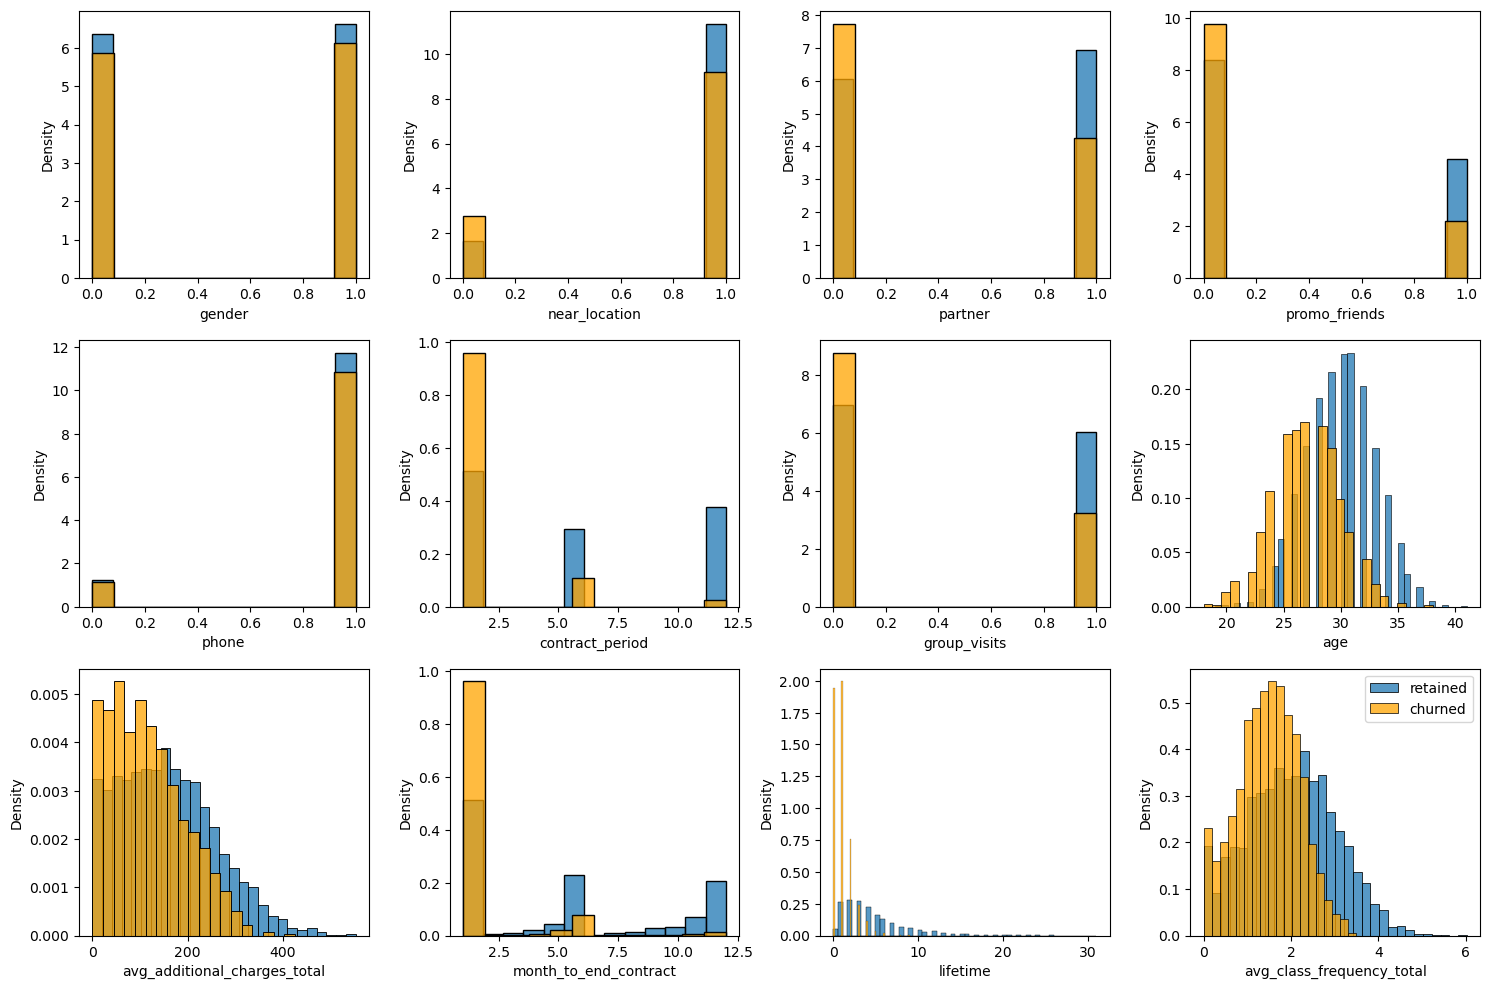

In [9]:
# построем столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался  

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for ax, feature in zip(axes, df.columns[0:15]):
    sns.histplot(df[df['churn'] == 0][feature], common_norm=False, stat="density", ax=ax)
    sns.histplot(df[df['churn'] == 1][feature], color="orange", common_norm=False, stat="density", ax=ax)

#fig.delaxes(axes[len(axes) - 1])
plt.legend(["retained", "churned"])
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

 <b> Промежуточные выводы </b>
    
Данные обезличены, все категориальные признаки приведены в числовой вид.
    
Для изучения данных посмотрела средние значения полей и стандартные отклонения, средние значения по признакам в разбивке по классам (churn/not churn), также посмотрела столбчатые гистограммы и распределение признаков:
    
- у категориальных признаков, приведенных в числовой вид бимодальное (у некоторых мультимодальное) распределение
- признаки Avg_additional_charges_total, Avg_class_frequency_total, Avg_class_frequency_current_month скошены влево, что означает что в выборке больше клиентов с меньшими показателями в данных признаках. 
- среднее признаков (кроме gender, phone) тех, кто ушел в отток меньше чем среднее оставшихся клиентов.     

- уже на данном этапе анализа можно отметить некоторые особенности группы отточных клиентов, например в признаках "near location", 'partner', 'promo_friends' если сравнить с гистограммой не отточной группы, клиенты в группе оттока больше распределяются в сторону нулевых значении. Что означает клиенты живущие далеко от зала, которые не являются сотрудниками партнерских компании и не пришли к нам по промо-акции больше подвержены оттоку. 
- по гистограммам контрактного периода, остаточного периода и lifetime - можно утверждать что большая часть клиентов, пришедших к нам с одномесячным контрактом не продлевают контракт дальше. 
- по гистограммам возраста, доп.расходов и среднего кол-ва посещении можно отметить что столбцы отточной группы сдвинуты влево отностиельно не отточной группы, что может означать что более молодые клиенты, которые не пользуются доп.услугами залов и в среднем реже посещают зал больше подвержены оттоку. 
    
В целом эти заметки означают что вышеуказанные признаки действительно оказывают влияние на дальнейшее поведение клиента. И необходимо определить оптимальные коэффициенты влияния каждого признака с помощью построения разных моделей дальше в проекте.

</div>

### Модели для прогнозирования оттока клиентов

In [12]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)

X = df.drop(columns=['churn'])
y = df['churn']

# разделяем модель на обучающую и валидационную выборку

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# обучим StandartScaler на обучающей выборке

scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [14]:
# определим функцию, которая будет выводить наши метрики

def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [15]:
# зададим алгоритм для модели логистической регрессии и обучим ее

lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы

lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [16]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса и обучим ее

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы

rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


<div class="alert alert-block alert-info">

 <b> Промежуточные итоги </b>
    
Accuracy двух моделей одинаковы - 92%. Однако необходимо рассмотреть показатели precision & recall чтобы решить какую модель целесообразно использовать в нашем случае.

Precision - доля правильных ответов только среди целевого класса, т.е. 85% среди тех, кого модель логистической регрессии спрогнозировал как отточные, реально ушли в отток. И 84% точности у модели на основе алгоритма случайного леса.
    
Recall - показывает сколько реальных объектов целевого класса модель обнаружила. Модель логистической регрессии - 83%, случайный лес - 81%. 
    
В нашем кейсе ложное срабатывание стоит меньше, чем если бы мы упустили реально отточного клиента. Т.е. лучше дать доп.скидку клиенту который не собирается нас покидать, чем упустить клиента который в следующем месяце уйдет в отток. Следовательно в нашем кейсе лучше использовать модель логистической регрессии.
    
</div>

### Кластеризация клиентов - формулировка портрета отточных клиентов

In [17]:
# создаём объект класса scaler, обучаем ее и преобразуем набор данных

scaler = StandardScaler() 
X_sc = scaler.fit_transform(df.drop(columns = ['churn']))

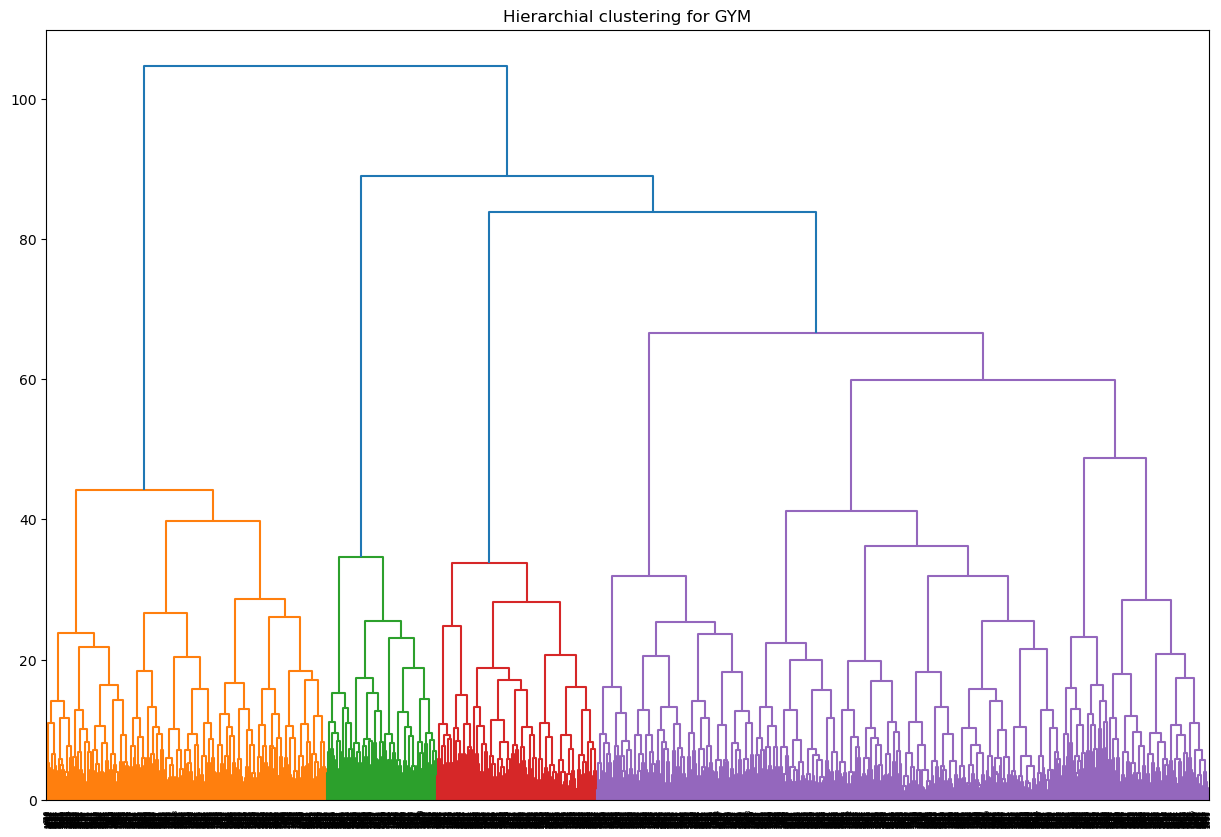

In [18]:
# построем матрицу расстоянии и нарисуем дендограмму

linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

<div class="alert alert-block alert-info">

 <b> Промежуточные выводы </b>
    
Для измерения "похожести" отдельных клиентов необходимо построить матрицу расстояний и нарисовать дендограмму.
На графике получилось 4 разных цветов, т.е. предложенное оптимальное число кластеров - 4. Начиная с 4 кластеров вертикальные разделы, где расстояния между кластерами на графике резко сокращаются. Поэтому оптимальное кол-во кластеров может быть в диапазоне 4-5.
    
</div>

In [19]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state

km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений 

labels = km.fit_predict(X_sc)

In [20]:
# сохраняем метки кластера в поле нашего датасета

df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру

display(df.groupby('cluster_km').mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


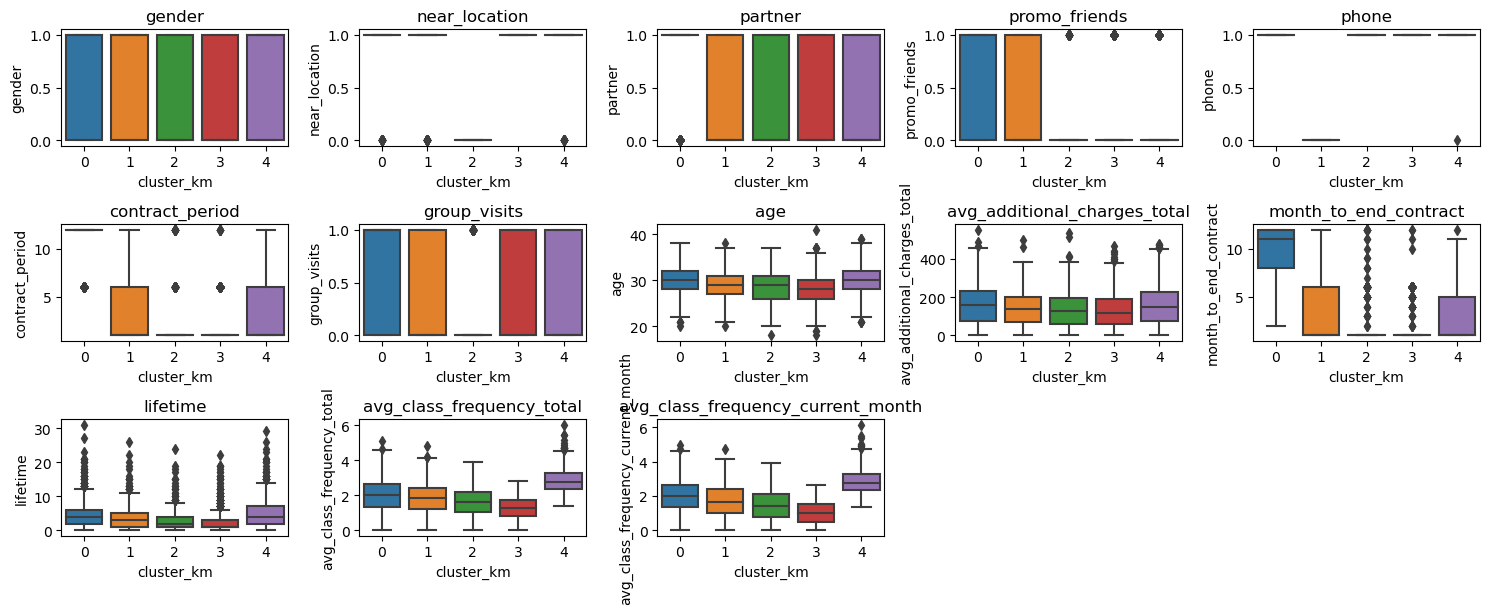

In [21]:
boxplot_cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
                'contract_period', 'group_visits', 'age',
                'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                'avg_class_frequency_total', 'avg_class_frequency_current_month']

# Отрисуем boxplot для каждого признака 
plt.figure(figsize=(15, 6))
for col in boxplot_cols:
    plt.subplot(3, 5, boxplot_cols.index(col) + 1)
    sns.boxplot(x='cluster_km', y=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.show()


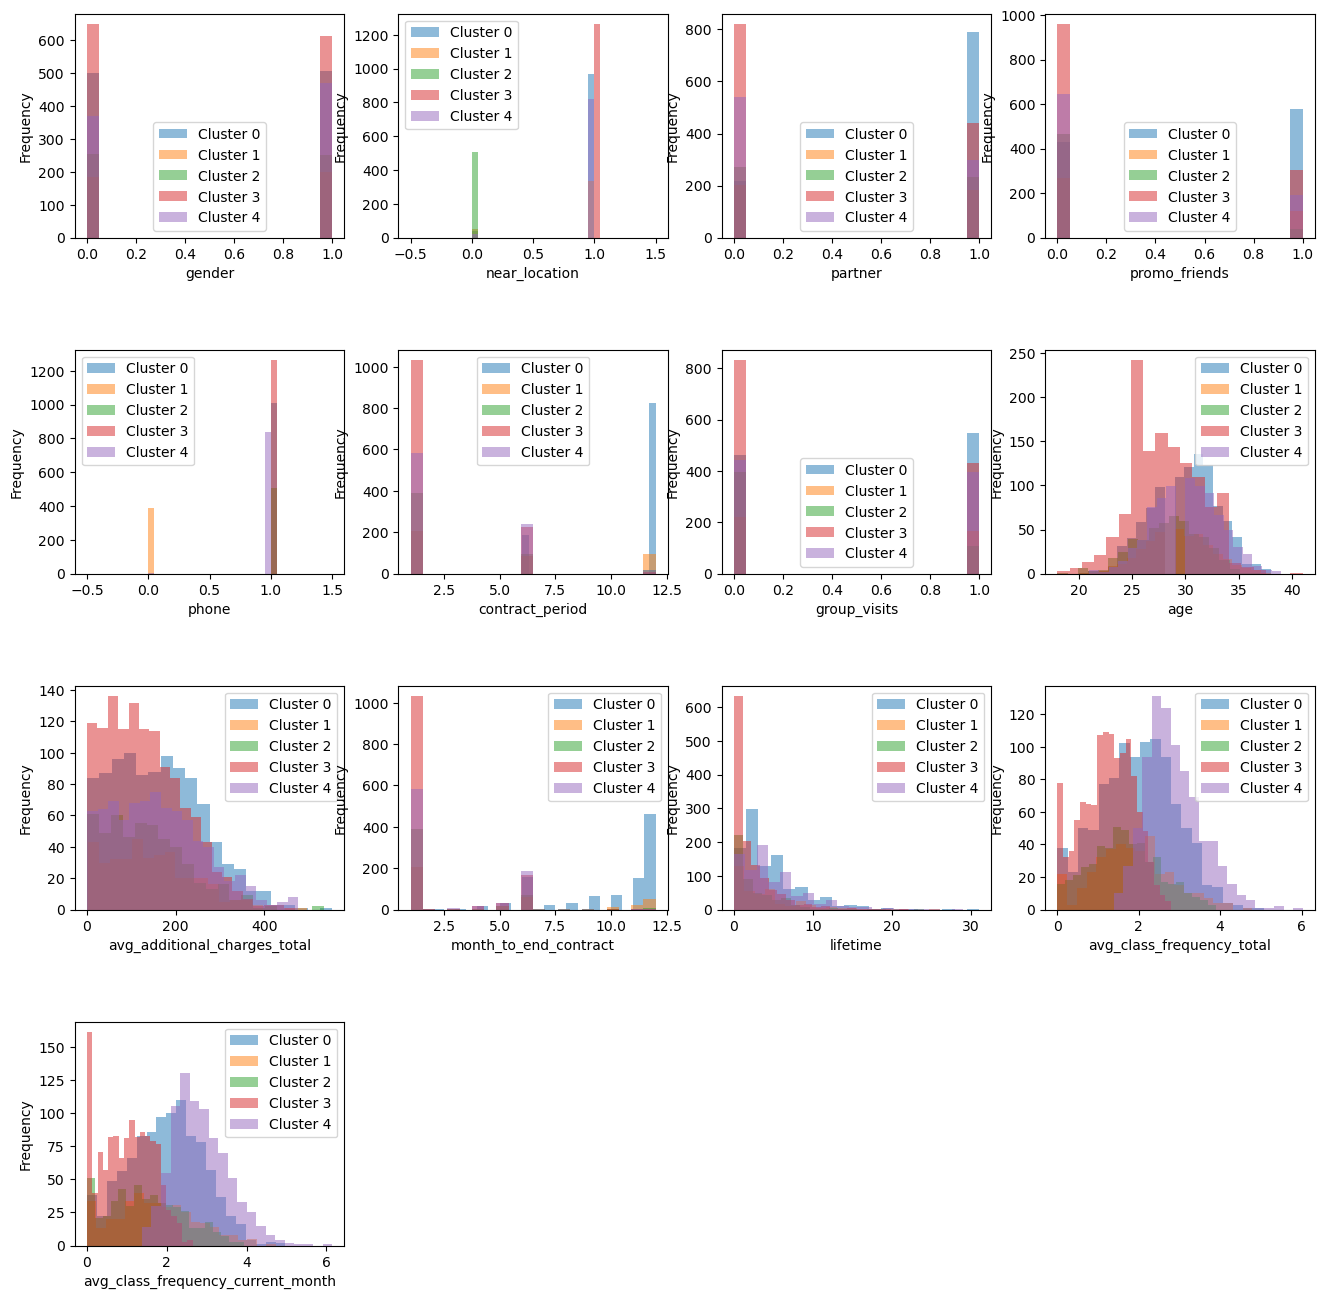

In [22]:
histogram_cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
                  'contract_period', 'group_visits', 'age',
                  'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                  'avg_class_frequency_total', 'avg_class_frequency_current_month']

# готовим ячейки для гистограммы каждого признака
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)

# отрисуем графики
for col, ax in zip(histogram_cols, axes.flatten()):
    for cluster in range(5):
        cluster_data = df[df['cluster_km'] == cluster]
        ax.hist(cluster_data[col], bins=20, alpha=0.5, label=f'Cluster {cluster}')
    
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()

# убираем пустые ячейки под графики
if len(histogram_cols) < 16:
    for ax in axes.flatten()[len(histogram_cols):]:
        ax.remove()

plt.show()


In [24]:
df_by_cluster = df.groupby('cluster_km')['churn'].agg(['sum', 'count', 'mean'])
df_by_cluster.columns = ['churned', 'total_cnt', 'churn_rate']
df_by_cluster

,churned,total_cnt,churn_rate
cluster_km,,,
0,28,1010,0.027723
1,103,385,0.267532
2,224,505,0.443564
3,649,1262,0.514263
4,57,838,0.068019


<div class="alert alert-block alert-info">
<b>Промежуточные выводы:</b> 
    
построила ящик с усами и гистограммы распределения признаков по кластерам. 

- в 2 и 3 кластер попадают клиенты с меньшим сроком договора (так же меньшее кол-во оставшихся месяцев занятий по договору), по сравнению с другими кластерами.
- средний возраст клиентов в 3-м кластере меньше чем в остальных, учитывая что в этом кластере максимальная доля отточных, возраст тоже может иметь косвенное влияние на отточность клиента.
- в 2 и 3 кластерах меньшие показатели по lifetime, и по среднему кол-ву посещении, так же по средним расходам за дополнительные услуги зала. 
  
По средним значениям признаков можно заключить:
- чем меньше срок договора клиента с сетью фитнес залов
- чем меньше оплаченного срока у клиента осталось
- чем реже он ходил в зал в последнем месяце и в целом за весь период - тем больше вероятности что клиент уйдет в отток. 
</div>

<div class="alert alert-block alert-info">

 <b> Рекомендации </b>
    
На основе проделанной работы можно привести следующие рекомендации: 
    
- для прогнозирования оттока в следующем месяце лучше использовать модель логистической регресии
- всем клиентам, которых модель определил как отточные - предложить небольшие бонусы, чтобы удержать их (бесплатные услуги тренера или лифлеты с описанием упражнении).
- клиентам, которые вдруг стали реже ходить и у которых есть контактный телефон - отправить уведомления на телефон. - при заключении договоров с новыми клиентами предлагать контракты с большим сроком действия (возможно сделать скидки в схеме "чем дольше срок - тем дешевле обойдется месяц занятии")
    
</div>